## HW4_siychen

### step 1

In [1]:
from webbrowser import get
import requests
import json

BASE_URL = "https://dsl.richmond.edu/panorama/redlining/static/downloads/geojson/MIDetroit1939.geojson" 
resp = requests.get(BASE_URL)
results_object = resp.json() 
feature_list = results_object["features"]


with open("./hw4.json", 'w+') as write_f:
    write_f.write(json.dumps(results_object, indent=4, ensure_ascii=True))

#print(type(results_object["features"][0]))
#print(feature_list[0]['properties'])

### step 2

In [2]:
class DetroitDistrict():
    def __init__(self,feature):
        self.coordinates = feature['geometry']['coordinates']
        self.holc_grade= feature['properties']['holc_grade'] 
        self.holc_color= self.get_color(self.holc_grade)

        self.name = feature['properties']['name']
        self.Qualitative_Description = feature['properties']['area_description_data']['8']
        self.RandomLat = [0, 0] #init lat randomly
        self.RandomLong = [0 ,0] #init long randomly
        self.CensusTract = []
        self.Median_Income = 0

    def get_color(self, grade):
        colors = {
            "A":"darkgreen",
            "B":"cornflowerblue",
            "C":"gold",
            "D":"maroon"
        }
        
        return colors.get(grade, None)
        
Districts = [DetroitDistrict(feature) for feature in feature_list]
#print(Districts[0].coordinates)

### step 3

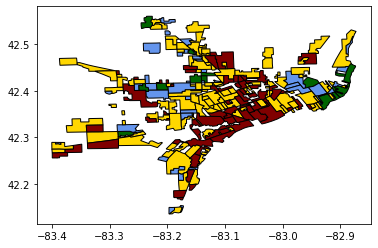

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.patches import Polygon

fig, ax = plt.subplots()
for i in Districts: # what kind of for loop makes sense? 
    # print(i.coordinates[0][0])
    # print("\n")
    xy= np.array(i.coordinates[0][0])
    p= Polygon(xy, facecolor=i.holc_color, closed=True, ec="black")
    ax.add_patch(p) # add arguments here 

ax.autoscale()
plt.rcParams["figure.figsize"] = (15,15)
plt.show()

### Step 4 & 5 & 6

In [4]:
import random as random
from matplotlib.path import Path 
import numpy as np 
random.seed(17) # make sure it choose same random number every time

xgrid = np.arange(-83.5,-82.8,.004)  # xgrid between -83.5 and -82.8, step is .004
ygrid = np.arange(42.1, 42.6, .004)  # ygrid between 42.1 and 42.6, step is .004
xmesh, ymesh = np.meshgrid(xgrid,ygrid) # Return coordinate matrices from coordinate vectors

points = np.vstack((xmesh.flatten(), ymesh.flatten())).T  #Stack arrays in sequence herizontally 

def census_tract(RandomLat, RandomLong):
    api_url = 'https://geo.fcc.gov/api/census/area?lat=' + str(RandomLat) + '&lon=' + str(RandomLong) + '&format=json'
    resp = requests.get(api_url)
    results_object = resp.json() 
    if results_object['results']!=0 :
        return results_object['results']

def get_income(RandomLat, RandomLong):
    census_tract_result = census_tract(RandomLat, RandomLong)
    stateCode = census_tract_result[0]["state_fips"]
    countyCode = census_tract_result[0]["county_fips"][2:5]
    tractCode = census_tract_result[0]['block_fips'][5:11]
#     print('stateCode' + stateCode + ', countyCode' + countyCode + ', tractCode' + tractCode + '\n')
    if stateCode and countyCode and tractCode:
        api_url ='https://api.census.gov/data/2015/acs/acs5?get=B19013_001E&for=tract:'+ tractCode + '&in=state:'+ stateCode +'%20county:' + countyCode + '&key=6e0e14fa5d764b8d4909d6b11e7ba714c3fa5315'
        resp = requests.get(api_url)
        if resp.status_code == 204:
            return 0
        else:
            results_object = resp.json()
            return results_object[1][0]
    else:
        return 0

for j in Districts:
    p = Path(j.coordinates[0][0]) #get the coordinate for every object 
    grid = p.contains_points(points) # return boolean indicating whether the coordinates contian the points generated 
    #print(j," : ", points[random.choice(np.where(grid)[0])]) 
    point = points[random.choice(np.where(grid)[0])] 
    j.RandomLong = point[0] #get longtitude of the point
    j.RandomLat = point[1] #get latitude of the point
    j.Median_Income = get_income(j.RandomLat, j.RandomLong)

### Step 7

In [5]:
A_income = []
B_income = []
C_income = []
D_income = []

def delete_zero(List):
    res = []
    for i in range(len(List)):
        if List[i] != 0:
            res.append(List[i])
        else:
            pass        
    return res

for j in Districts:
    if j.holc_grade == "A":
        A_income.append(int(j.Median_Income))
    elif j.holc_grade == "B":
        B_income.append(int(j.Median_Income))
    elif j.holc_grade == "C":
        C_income.append(int(j.Median_Income))
    elif j.holc_grade == "D":
        D_income.append(int(j.Median_Income))
        
A_income = delete_zero(A_income)
B_income = delete_zero(B_income)
C_income = delete_zero(C_income)
D_income = delete_zero(D_income)

A_mean_income = np.mean(A_income)
B_mean_income = np.mean(B_income)
C_mean_income = np.mean(C_income)
D_mean_income = np.mean(D_income)

A_median_income = np.median(A_income)
B_median_income = np.median(B_income)
C_median_income = np.median(C_income)
D_median_income = np.median(D_income)

# print(A_income)
# print(B_income)
# print(C_income)
# print(D_income)


print("A_mean_income:",round(A_mean_income,1))
print("B_mean_income:",round(B_mean_income,1))
print("C_mean_income:",round(C_mean_income,1))
print("D_mean_income:",round(D_mean_income,1))

print("A_median_income:",A_median_income)
print("B_median_income:",B_median_income)
print("C_median_income:",C_median_income)
print("D_median_income:",D_median_income)

A_mean_income: 88899.1
B_mean_income: 56089.2
C_mean_income: 38359.5
D_mean_income: 27374.7
A_median_income: 107768.0
B_median_income: 57087.0
C_median_income: 29398.0
D_median_income: 23650.0


### Step 8

In [6]:
A_Description=''
B_Description=''
C_Description=''
D_Description=''

for j in Districts:
    if j.holc_grade == "A":
        A_Description = A_Description + j.Qualitative_Description
    if j.holc_grade == "B":
        B_Description = B_Description + j.Qualitative_Description
    if j.holc_grade == "C":
        C_Description = C_Description + j.Qualitative_Description
    if j.holc_grade == "D":
        D_Description = D_Description + j.Qualitative_Description
                

four_dict={'A':A_Description, 'B':B_Description, 'C':C_Description,'D':D_Description}

import re
for i in four_dict.keys():
    four_dict[i]= four_dict[i].lower()
    four_dict[i]= re.findall(r'[\w]+', four_dict[i])

In [7]:
word_counts={'A':{}, 'B':{}, 'C':{},'D':{}}
for i in four_dict.keys():
    for j in four_dict[i]:
        if j not in word_counts[i].keys():
             word_counts[i][j]= 0
        else:
            word_counts[i][j] +=1


In [8]:
filler_words=['the','of','is','are','and','a','in','a','as','to','for','on','at','all','not','an','there','this','with','but','very']
for i in word_counts.keys():
    #print(str(word_counts[i].keys()))
    digit=re.findall('\d+', str(word_counts[i].keys()))
    for j in list(word_counts[i].keys()): 
        if j.isnumeric() is True:
            if j in digit:
                del word_counts[i][j]
        elif j.isnumeric() is False: 
            if j in filler_words:
                del word_counts[i][j]

In [9]:
#sort order
for i in word_counts.keys():
    word_counts[i] = sorted(word_counts[i].items(), key=lambda x: x[1], reverse=True)

In [10]:
A_10_Most_Common = [x[0] for x in word_counts['A'][0:10]]
B_10_Most_Common = [x[0] for x in word_counts['B'][0:10]]
C_10_Most_Common = [x[0] for x in word_counts['C'][0:10]]
D_10_Most_Common = [x[0] for x in word_counts['C'][0:10]]
print('A_10_Most_Common:', A_10_Most_Common)
print('B_10_Most_Common:', B_10_Most_Common)
print('C_10_Most_Common:', C_10_Most_Common)
print('D_10_Most_Common:', D_10_Most_Common)

A_10_Most_Common: ['area', 'section', 'good', 'neighborhood', 'high', 'well', 'houses', 'detroit', 'class', 'development']
B_10_Most_Common: ['area', 'houses', 'good', 'streets', 'section', 'transportation', 'new', 'developed', 'singles', 'up']
C_10_Most_Common: ['area', 'houses', 'flats', 'singles', 'see', 'explanation', 'sheet', 'grade', 'descriptions', 'from']
D_10_Most_Common: ['area', 'houses', 'flats', 'singles', 'see', 'explanation', 'sheet', 'grade', 'descriptions', 'from']


### Bonus 1

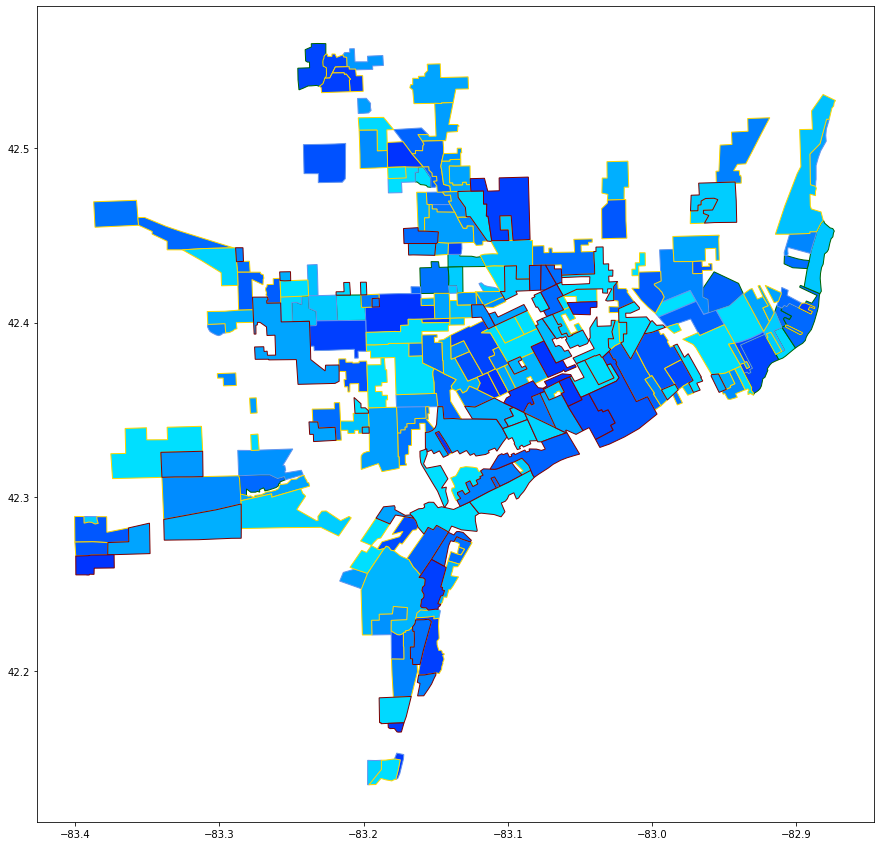

In [11]:
import matplotlib.cm as cm
# def get_fc_color(income):
#     r = income%255
#     g = income%255
#     b = income%255
#     return ('#{:X}{:X}{:X}').format(r, g, b)
    
fig, ax = plt.subplots()
for i in Districts:
    # print(i.coordinates[0][0])
    # print("\n")
    xy = np.array(i.coordinates[0][0])
    p = Polygon(xy, facecolor=i.holc_color, closed=True, ec=i.holc_color, fc=cm.hsv(int(i.Median_Income)%30+135))
    ax.add_patch(p) # add arguments here 

ax.autoscale()
plt.rcParams["figure.figsize"] = (15,15)
plt.show()

### Bonus 2

Q : Did the results in Step 6 or 7 surprise you?

The household income matched with the letter grades assigned to four neighborhoods. A (marked in green) has the highest mean and median income. They are the best ones because they're ethnically homogenous and had room to be further developed. B has the second highest mean and median income, followed by B and then C. 


Q : Have these 2 HW assignments changed your prior understanding of segregation in any way? What
systemic effects would you want to simulate with the python skills you have now?

Yes. From this hw, we can see that segregation and redlining can lead to income disparity to different communities. Or you can say redlining is connected with social-economic factors and develop interactively. 
I want to examinate other social-economic factors, like education and race, to see how they're connected with redlining. I also want to simulate if we change one social-economic factor for communities with different letter grade (or vice versa), how would the outcome change. 

